In [6]:
conda install pytorch torchvision torchaudio cpuonly -c pytorch


Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.




==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2




In [7]:
import os
import torch
import torchvision
import torchvision.transforms as t
import matplotlib.pyplot as plt
import numpy as np

In [8]:
os.listdir("C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/training/training")

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [9]:
training_data_path = "C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/training/training"

In [10]:
training_transform = t.Compose([t.Resize((150,150)), t.ToTensor()])

In [11]:
train_data = torchvision.datasets.ImageFolder(root = training_data_path, transform = training_transform)

In [12]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = 32, shuffle = False)

In [13]:
def get_mean_and_std(loader):
    mean = 0
    std = 0
    total_images_count = 0
    for images, _ in loader:
        image_count_in_a_batch = images.size(0)
        #print(images.shape)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        #print(images.shape)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
        
    mean /= total_images_count
    std /= total_images_count
    
    return mean, std

In [14]:
get_mean_and_std(train_loader)

(tensor([0.4363, 0.4328, 0.3291]), tensor([0.2099, 0.2046, 0.2005]))

In [15]:
test_data_path = "C:/Users/linh0/PycharmProjects/Image-classification-project/dataset/validation/validation"

In [16]:
# normalize image = (image - mean)/std
mean = [0.4363, 0.4328, 0.3291]
std = [0.2135, 0.2081, 0.2044]

train_transforms = t.Compose([
    t.Resize((150,150)), 
    t.RandomHorizontalFlip(),
    t.RandomRotation(10),
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std))
    
])
#since it is a test dataset we do not flip or rotate it
test_transforms = t.Compose([
    t.Resize((150,150)), 
    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std))
])

In [17]:
train_dataset = torchvision.datasets.ImageFolder(root = training_data_path, transform = train_transforms)
test_dataset = torchvision.datasets.ImageFolder(root = test_data_path, transform = test_transforms)

In [18]:
def show_transformed_images(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
    batch = next(iter(loader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow = 3)
    plt.figure(figsize = (11,11))
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    print('labels: ', labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels:  tensor([2, 5, 2, 7, 4, 8])


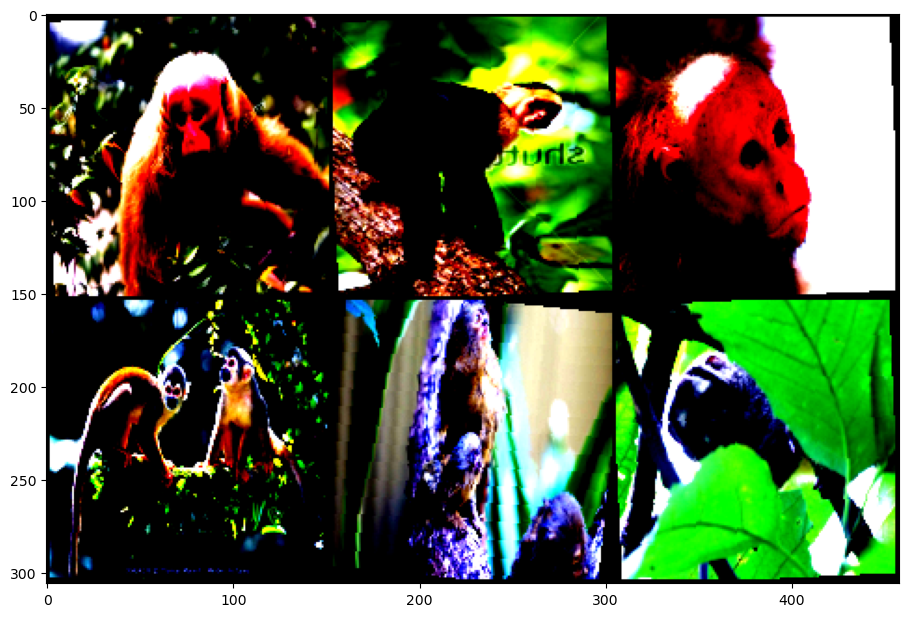

In [19]:
show_transformed_images(train_dataset)

In [20]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 64, shuffle = False)
#either try 32, 64 or 128 for batch_size

In [21]:
def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

In [31]:
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    device = set_device()
    best_acc = 0
    
    for epoch in range(n_epochs):
        print('Epoch number %d '
             % (epoch + 1))
        model.train()
        running_loss = 0.0
        running_correct = 0.0
        total = 0
        
        for data in train_loader:
            images, labels = data
            image = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            
            optimizer.zero_grad()
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, labels)
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()
            
        epoch_loss = running_loss/len(train_loader)
        epoch_acc = 100.00 * running_correct / total
        
        print("    - Training dataset. Got %d out of %d images correctly (%.3f%%). Epoch loss: %.3f"
             % (running_correct, total, epoch_acc, epoch_loss))
        
        test_dataset_acc = eval_model_test_set(model, test_loader)
        if (test_dataset_acc > best_acc):
            best_acc = test_dataset_acc
            save_checkpoint(model, epoch, optimizer, best_acc)
        
        
    print("Finished")
    return model

In [23]:
def eval_model_test_set(model, test_loader):
    model.eval()
    predicted_correctly_on_epoch = 0
    total = 0
    device = set_device()
    
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            total += labels.size(0)
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            
            predicted_correctly_on_epoch += (predicted == labels).sum().item()
            
    epoch_acc = 100.00 * predicted_correctly_on_epoch / total
        
    print("    - Testing dataset. Got %d out of %d images correctly (%.3f%%)"
             % (predicted_correctly_on_epoch, total, epoch_acc))
    
    return epoch_acc
    
    
        

In [33]:
def save_checkpoint( model, epoch, optimizer, best_acc):
    state = {
        'epoch': epoch +1,
        'model': model.state_dict(),
        'best_accuracy': best_acc,
        'optimizer' : optimizer.state_dict(),
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [25]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

resnet18_model = models.resnet18(weights = None) #pretrained = False: weights = None; pretrained = True: weights=ResNet18_Weights.DEFAULT
num_ftrs = resnet18_model.fc.in_features
num_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, num_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
# SGD = Stochastic gradient descent
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
# parameters controls how much the model change in respond to the standard error
# lr choose 0.1 to 0.001

In [26]:
#train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 100) #training with no weights

In [27]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet18_Weights #importing the model from torchvision

resnet18_model = models.resnet18(weights=ResNet18_Weights.DEFAULT) #pretrained = False: weights = None; pretrained = True: weights=ResNet18_Weights.DEFAULT
num_ftrs = resnet18_model.fc.in_features
num_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, num_of_classes)
device = set_device()
resnet_18_model = resnet18_model.to(device)
loss_fn = nn.CrossEntropyLoss()
# SGD = Stochastic gradient descent
optimizer = optim.SGD(resnet18_model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.003)
# parameters controls how much the model change in respond to the standard error
# lr choose 0.1 to 0.001

In [40]:
train_nn(resnet18_model, train_loader, test_loader, loss_fn, optimizer, 40) #pretrained = True

Epoch number 1 
    - Training dataset. Got 1092 out of 1097 images correctly (99.544%). Epoch loss: 0.016
    - Testing dataset. Got 263 out of 272 images correctly (96.691%)
Epoch number 2 
    - Training dataset. Got 1091 out of 1097 images correctly (99.453%). Epoch loss: 0.023
    - Testing dataset. Got 263 out of 272 images correctly (96.691%)
Epoch number 3 
    - Training dataset. Got 1090 out of 1097 images correctly (99.362%). Epoch loss: 0.022
    - Testing dataset. Got 264 out of 272 images correctly (97.059%)
Epoch number 4 
    - Training dataset. Got 1088 out of 1097 images correctly (99.180%). Epoch loss: 0.034
    - Testing dataset. Got 261 out of 272 images correctly (95.956%)
Epoch number 5 
    - Training dataset. Got 1089 out of 1097 images correctly (99.271%). Epoch loss: 0.038
    - Testing dataset. Got 261 out of 272 images correctly (95.956%)
Epoch number 6 
    - Training dataset. Got 1090 out of 1097 images correctly (99.362%). Epoch loss: 0.032
    - Testing

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
checkpoint = torch.load('model_best_checkpoint.pth.tar')

In [42]:
print(checkpoint['epoch'])
print(checkpoint['best_accuracy'])

38
97.79411764705883


In [43]:
resnet18_model = models.resnet18() 
num_ftrs = resnet18_model.fc.in_features
num_of_classes = 10
resnet18_model.fc = nn.Linear(num_ftrs, num_of_classes)
resnet18_model.load_state_dict(checkpoint['model'])

torch.save(resnet18_model, 'best_model.pth')

In [45]:
import PIL.Image as Image

classes = [
        'Mantled Howler',
          'Patas monkey',
           'Bald Uakari',
           'Japanese Macaque',
           'Pygmy Marmoset',
           'White Headed Capuchin',
           'Silvery Marmoset',
           'Common Squirrel Monkey',
           'Black Headed Night Monkey',
           'Nilgiri Langur',
          ]

In [46]:
model = torch.load('best_model.pth')

In [49]:
mean = [0.4363, 0.4328, 0.3291]
std = [0.2135, 0.2081, 0.2044]

image_transforms = t.Compose([
    t.Resize((150,150)), 

    t.ToTensor(),
    t.Normalize(torch.Tensor(mean), torch.Tensor(std))
    
])

In [50]:
def classify(model, image_transforms, image_path, classes):
    model = model.eval()
    image = Image.open(image_path)
    image = image_transforms(image).float()
    image = image.unsqueeze(0)
    
    output = model(image)
    _, predicted = torch.max(output.data, 1)
    
    print(classes[predicted.item()])
    
    
    

In [51]:
classify(model, image_transforms, "image to test classification/patas_monke_test.jpg", classes)#correct

Patas monkey


In [52]:
classify(model, image_transforms, "image to test classification/bald_uakari_test.jpg", classes)#correct

Bald Uakari


In [54]:
classify(model, image_transforms, "image to test classification/pygmy_marmoset_test.jpg", classes) #correct

Pygmy Marmoset
